In [34]:
import os
import time

import json

from operator import itemgetter

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

## Load Json Data

In [35]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [36]:
# load business data
path = "dataset/Peoria_Data/Peoria_business.json"
business_list = read_josn(path)
# load reviews data
path = "dataset/Peoria_Data/Peoria_Review.json"
review_list = read_josn(path)
# load user data
path = "dataset/Peoria_Data/Peoria_User.json"
user_list = read_josn(path)

## Transform to dataframe

In [37]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,Q1GhjqlLENaT383k9Ex5wg,1,Daily Donut
1,cz5kBEZMHKyJ_nZXn-IRIA,2,Hall Brent R DDS
2,U1iF2RC18uBgBe01z5BMXw,3,Church's Chicken
3,9eY5ZfKPc_oz6Co5WCPynQ,4,Fullerton Financial Planning
4,aERMWmIT6yJVGYIn4qQizQ,5,GO AZ Motorcycles


In [38]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,eSlOI3GhroEtcbaD_nFXJQ,1,Jason
1,U4INQZOPSUaj8hMjLlZ3KA,2,Michael
2,xZAmw5gihOVO4duMN2Ju6Q,3,Flynn
3,F78tJHr0qW6FsYBtWMmLpA,4,Christopher
4,TUE3NJYN4i7xyGVSIXMLvw,5,Kymberly


In [39]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,5042,153,5.0
1,5763,50,5.0
2,79,58,1.0
3,6284,63,5.0
4,4844,130,2.0


## Filter Data

### For Business

In [40]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,33
2,4
3,3
4,4
5,44


In [41]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    620.0
0.95    124.2
0.90     71.0
0.85     46.0
0.80     34.0
0.75     27.0
0.70     21.0
0.65     18.0
Name: count, dtype: float64

In [42]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (57857, 3)
shape of ratings data after dropping unpopular business:  (53338, 3)


### For Users

In [43]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,1
2,2
3,6
4,10
6,7


In [44]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    109.0
0.95      5.0
0.90      3.0
0.85      2.0
0.80      2.0
0.75      2.0
0.70      1.0
0.65      1.0
0.60      1.0
0.55      1.0
Name: count, dtype: float64

In [45]:
# filter data
ratings_thres = 3
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (57857, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (23675, 3)


In [46]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))
df_ratings_drop_users

,userId,businessId,rating
0,79,58,1.0
1,4844,130,2.0
2,1598,78,5.0
3,3163,16,3.0
4,2015,34,5.0
...,...,...,...
23670,22959,1821,1.0
23671,15889,1740,4.0
23672,3020,1831,5.0
23673,4671,1831,5.0


In [47]:
# the number of users and movies
num_users = len(df_ratings_drop_users.userId.unique())
num_items = len(df_ratings_drop_users.businessId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 4090 unique users and 1007 unique movies in this data set


## Transform dataframe to dictionary

In [48]:
dataDic = {}
dataDic_len = 0
# 遍历data的每一行， 把userId, movidId, rating按照{user: {movidId: rating}}的方式存储， 当然定义一个随机种子进行数据集划分
for ele in df_ratings_drop_users.itertuples():   # 遍历行这里推荐用itertuples， 比iterrows会高效很多
    user, business, rating = getattr(ele, 'userId'), getattr(ele, 'businessId'), getattr(ele, 'rating')
    
    dataDic.setdefault(user, {})
    dataDic[user][business] = rating
    dataDic_len += 1
    
print('dataDic = %s' % dataDic_len)

dataDic = 23675


## Get Similarity

In [49]:
# 计算每部电影的流行程度, 也就是每部电影被用户看的总次数， 这个衡量相似度的时候作为分母
business_popular = {}
for user, businesses in dataDic.items():   # 这里的user就是每个用户， movies还是个字典， {movieID: rating}
    for business in businesses:       # 这里的movie就是movieID了
        if business not in business_popular:     
            business_popular[business] = 0  
        business_popular[business] += 1


business_count = len(business_popular)
print('Total business number = %d' % business_count)


# 下面建立电影相似矩阵
print('Build user co-rated movies matrix ...')
business_sim_matrix = {}
for user, businesses in dataDic.items():     # 注意这个地方与UserCF的不同
    for b1 in businesses:           # 对于每个电影， 都得双层遍历
        for b2 in businesses:
            if b1 == b2:
                continue
            business_sim_matrix.setdefault(b1, {})      # 把字典的值设置为字典的形式
            business_sim_matrix[b1].setdefault(b2, 0)
            
            # 753 cos-sim 分子
            business_sim_matrix[b1][b2] += businesses[b1]*businesses[b2]
            
print('Build user co-rated businesses matrix success!')


# 753 cos-sim 分母
temp_sim = {}
for user, businesses in dataDic.items():
    for b in businesses:
        if b not in temp_sim:     
            temp_sim[b] = 0  
        temp_sim[b] += math.pow(businesses[b],2)

# 下面计算电影之间的相似性
print('Calculating movies similarity matrix ...')
for b1, related_businesses in business_sim_matrix.items():
    for b2, count in related_businesses.items():    # 这里面m2是相关电影， count是共同被同一个用户打分的次数
        # 这里注意零向量的处理， 即某电影的用户数为0   
        # 753-cos
        if temp_sim[b1] == 0 or temp_sim[b2] == 0:
            business_sim_matrix[b1][b2] = 0
        else:
            #753-cos
            business_sim_matrix[b1][b2] = count / math.sqrt(temp_sim[b1] * temp_sim[b2]) 
print('Calculate movies similarity matrix success!')

Total business number = 1007
Build user co-rated movies matrix ...
Build user co-rated businesses matrix success!
Calculating movies similarity matrix ...
Calculate movies similarity matrix success!


In [50]:
# 这里先把产生推荐的那个封装成函数才能测试所有的测试样本
def recommend(aim_user, data, sim_matrix, k=20, n=20):
    rank ={}
    rated_businesses = data[aim_user]      # 找出目标用户看到电影
    
    # 753
    w_sum = {}
    R = {}
    
    for business, rating in rated_businesses.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_businesses:
                continue

            # 计算用户user对related_business的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            #通过与其相似物品对物品related_business的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * (rating)
            w_sum[related_business] += w
    
    # 753
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid])
    
    #print(rank)
    # 产生最后的推荐列表
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法
    
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position

#### 一个例子

In [51]:
aim_user = 1202
recom_list, rank_posi = recommend(aim_user, dataDic, business_sim_matrix,k=50,n=50)

In [52]:
recom_list

[(714, 3.0000000000000004),
 (659, 3.0000000000000004),
 (1894, 3.0000000000000004),
 (1124, 3.0000000000000004),
 (1612, 3.0000000000000004),
 (284, 3.0000000000000004),
 (1734, 3.0000000000000004),
 (1482, 3.0000000000000004),
 (943, 3.0000000000000004),
 (339, 3.0000000000000004),
 (1236, 3.0),
 (1837, 3.0),
 (1891, 3.0),
 (118, 3.0),
 (919, 3.0),
 (312, 3.0),
 (1043, 3.0),
 (1378, 3.0),
 (1152, 3.0),
 (1717, 3.0),
 (623, 3.0),
 (1748, 3.0),
 (786, 3.0),
 (1100, 3.0),
 (185, 3.0),
 (741, 3.0),
 (1188, 3.0),
 (256, 3.0),
 (1351, 3.0),
 (280, 3.0),
 (1384, 3.0),
 (1739, 3.0),
 (1128, 3.0),
 (682, 3.0),
 (1869, 3.0),
 (1246, 3.0),
 (86, 3.0),
 (1362, 3.0),
 (1002, 3.0),
 (473, 3.0),
 (229, 3.0),
 (1504, 3.0),
 (1857, 3.0),
 (1859, 3.0),
 (1065, 3.0),
 (883, 3.0),
 (1008, 3.0),
 (500, 3.0),
 (457, 3.0),
 (995, 3.0)]

In [53]:
rank_posi

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

## PRU

In [54]:
from scipy import stats

def get_SRC(recom_list, rank_posi, business_popular):
    # popularity list
    popularity = []
    for bid, rating in recom_list:
        popularity.append(business_popular[bid])
    
    SRC,_ = stats.spearmanr(rank_posi, popularity)
    
    return SRC    

In [55]:
get_SRC(recom_list, rank_posi, business_popular)

-0.31678319938220534

In [56]:
# 这一步对于小数据集，需要10min左右
# print的目的是，查看运行到哪里，可删除
SRC_list = []
SRC = 0
pop_list = []
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, rank_posi = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    SRC = get_SRC(recom_list, rank_posi, business_popular)
    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)

In [57]:
PRU

-0.10455556569696013

In [58]:
len(SRC_list)

4090

In [59]:
print(np.argwhere(np.isnan(SRC_list)))

[]


In [60]:
-np.sum(list(map(lambda x: 0.0 if math.isnan(x) else x, SRC_list)))/18612

-0.022976158591261925

## Plot Frequency

In [61]:
rec_business_popular = business_popular
rec_freq = {}
for b in rec_business_popular:
    rec_freq.setdefault(b, 0)
    
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, _ = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    for rec in recom_list:
        rec_freq[rec[0]] += 1

Text(0.5, 1.0, 'ItemCF')

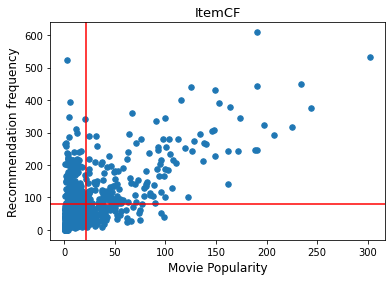

In [62]:
import matplotlib.pyplot as plt

x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=30,marker='o')
plt.axhline(y = rec_mean, color = "r", linestyle = "-")
plt.axvline(x = pop_mean, color = "r", linestyle = "-")

plt.xlabel('Movie Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('ItemCF', fontsize=13)

## Rerank

In [63]:
# 这里先把产生推荐的那个封装成函数才能测试所有的测试样本
def recommend_rerank(aim_user, data, sim_matrix, k=20, n=20):
    rank ={}
    rated_businesses = data[aim_user]      # 找出目标用户看到电影
    
    # 753
    w_sum = {}
    R = {}
    
    for business, rating in rated_businesses.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_businesses:
                continue

            # 计算用户user对related_business的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            #通过与其相似物品对物品related_business的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * (rating)
            w_sum[related_business] += w
    
    # 753
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid])
    
    #print(rank)
    # 产生最后的推荐列表
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法
    
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position